## Getting started

In order to run one of DIANNA's XAI methods, you first need one or more input data, and a pre-trained model in onnx format.

#### Install

The model we are using takes two arrays as input, and DIANNA does not include automatic multiple inputs handling yet. Thus we modified the source code in the branch [gc_lorentz](https://github.com/dianna-ai/dianna/tree/gc_lorentz) to handle such a case, only for this very specific model. We plan to insert such functionality in DIANNA's package in the near future, but for know you need to clone `gc_lorentz` DIANNA's branch and pip install it. Instructions from the terminal:

- `cd` to your machine location in which you wish to clone DIANNA's repo. 
- `git clone git@github.com:dianna-ai/dianna.git`
- `cd dianna`
- `git checkout gc_lorentz`
- Make sure to be in an appropriate virtual environment. 
- `pip install .`
- `pip install -U tf2onnx`

#### Save samples data


```
scratchdir = Path("<data_path>")
experiment_name = "<experiment_name>"
test_inputs = np.load(scratchdir / f"{experiment_name}.testing_inputs.npy")
test_target = np.load(scratchdir / f"{experiment_name}.testing_terciles.npy")

np.save("test_<year_used_for_testing>/test<n_sample>_inputs.npy", test_inputs[n_sample])
np.save("test_<year_used_for_testing>/test<n_sample>_target.npy", test_target[n_sample])

```

#### Save Keras model

Considering to have a `ModelRegistry` instance called `registry`, that contains all the cross-validated models (see `pipeline.ipynb`), you can save one of them, for example the last one, in the following way:

```
registry.registry[-1].save("test_<year_used_for_testing>/pre-trained")
```

In [13]:
from tensorflow import keras
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append("..") # Adds higher directory to python modules path
from cnn_training import generate_climprob_inputs
import onnxruntime

#### Convert to Onnx model

In [14]:
keras_model_file = "test_2020/pre-trained"
onnx_model_file = "test_2020/pre-trained.onnx"

In [15]:
!python3 -m tf2onnx.convert --saved-model {keras_model_file} --output {onnx_model_file} --signature_def serving_default --tag serve

/usr/bin/python3: Error while finding module specification for 'tf2onnx.convert' (ModuleNotFoundError: No module named 'tf2onnx')


### Select and visualize input data

Now that you have samples data and the model in .onnx format, you can visualize inputs for which you may need an explaination from DIANNA.

In [22]:
data_input = np.load("test_2020/test_inputs_3-6.npy")
data_target = np.load("test_2020/test_target_3-6.npy")
data_climprobs = np.load("test_2020/climprobs.npy")

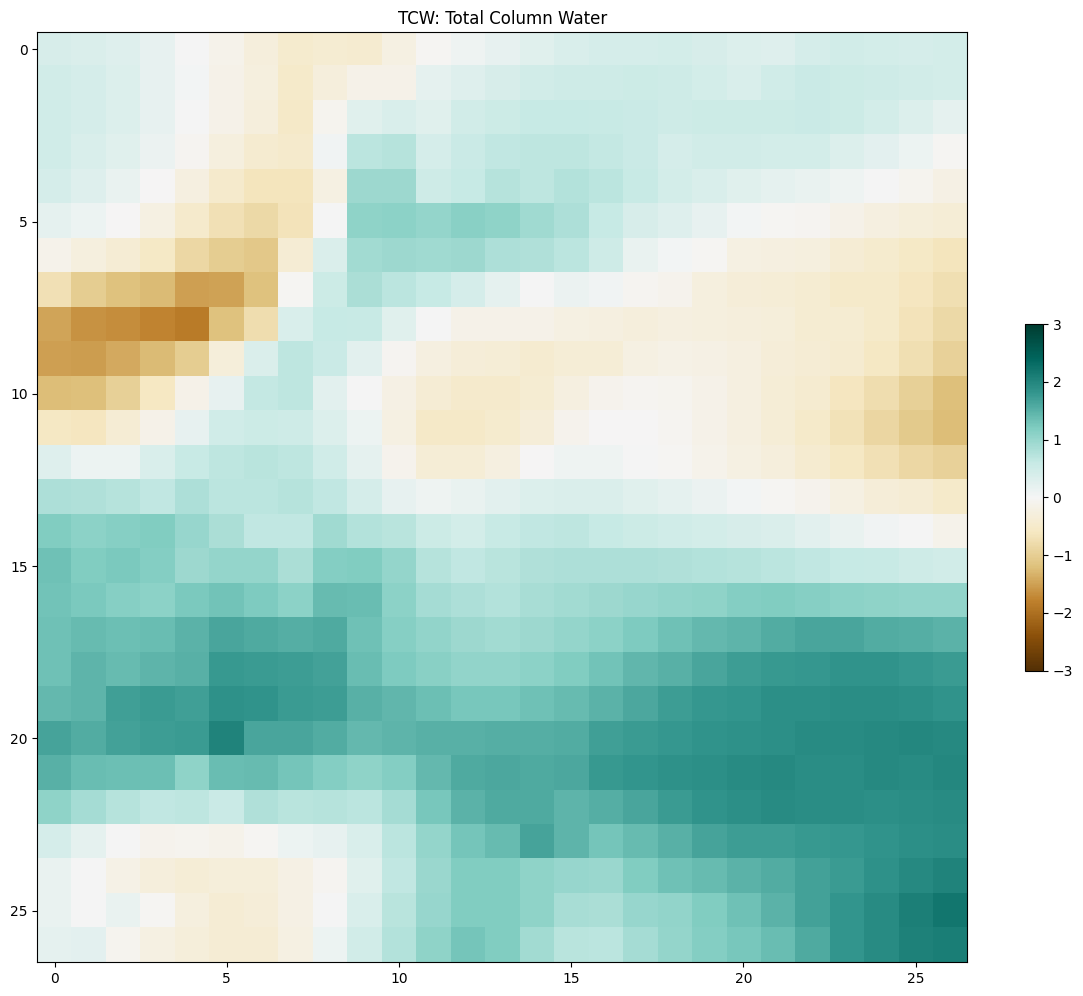

In [21]:
subpl = ['TCW: Total Column Water']
cmaps = ['BrBG']

fig, axs = plt.subplots(1, 1, figsize=(15, 15))

#fig.text(0.5, 0.35, 'Latitude', ha='center')
#fig.text(0.08, 0.5, 'Longitude', va='center', rotation='vertical')

ax = axs
tp = ax.imshow(data_input[:,:,col], cmap=cmaps[col], vmin = -3, vmax = 3)
cbar = fig.colorbar(tp, ax = ax, shrink = 0.3)
ax.title.set_text(subpl[col])

### Run the model

#### Define preprocessing function

The model takes as input two arrays, and the second is derived from the first one. 
Since methods like RISE require a single image or a single image-like data as input, we need to encode in a function the processing of the single input array into two arrays (that are inputs for the pre-trained model).

In [24]:
def preprocess_function(data):
    clim_logprobs = generate_climprob_inputs(data, climprobs = data_climprobs)
    return [data, clim_logprobs]

#### Define function to run the model

In [25]:
def run_model(data):
    fname = onnx_model_file
    # get ONNX predictions
    sess = onnxruntime.InferenceSession(fname)
    output_name = sess.get_outputs()[0].name
    
    data = np.expand_dims(data, axis=0)
    data = preprocess_function(data)
    
    onnx_input = {}
    onnx_input['input_3'] = data[1].astype('float32')
    onnx_input['input_4'] = data[0].astype('float32')
    pred_onnx = sess.run([output_name], onnx_input)[0]
    
    return pred_onnx

In [35]:
pred = run_model(data_input)
class_idx = np.argmax(pred)
print(f'Target array is {data_target.astype(int)}.')
print(f'Predictions for each class are {[round(x, 2) for x in pred[0]]}.\n')
print(f'Model\'s predicted class idx is {class_idx}.')

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Invalid Feed Input Name:input_4

### DIANNA

In [61]:
import dianna

#### Running RISE via DIANNA

In [64]:
relevances = dianna.explain_image(
    onnx_model_file,
    data_input,
    method = "RISE",
    labels = data_target.astype('int'),
    n_masks = 5000,
    feature_res = 8,
    p_keep = .1,
    axis_labels = ('height','width','channels'),
    preprocess_function = preprocess_function,
    multiple_inputs = True)

print(relevances.shape)

!! Modified RISE for multiple input use case !!


Explaining: 100%|██████████| 50/50 [00:00<00:00, 194.50it/s]

(3, 27, 27)


We obtained an array containing one relevance map for each target class.

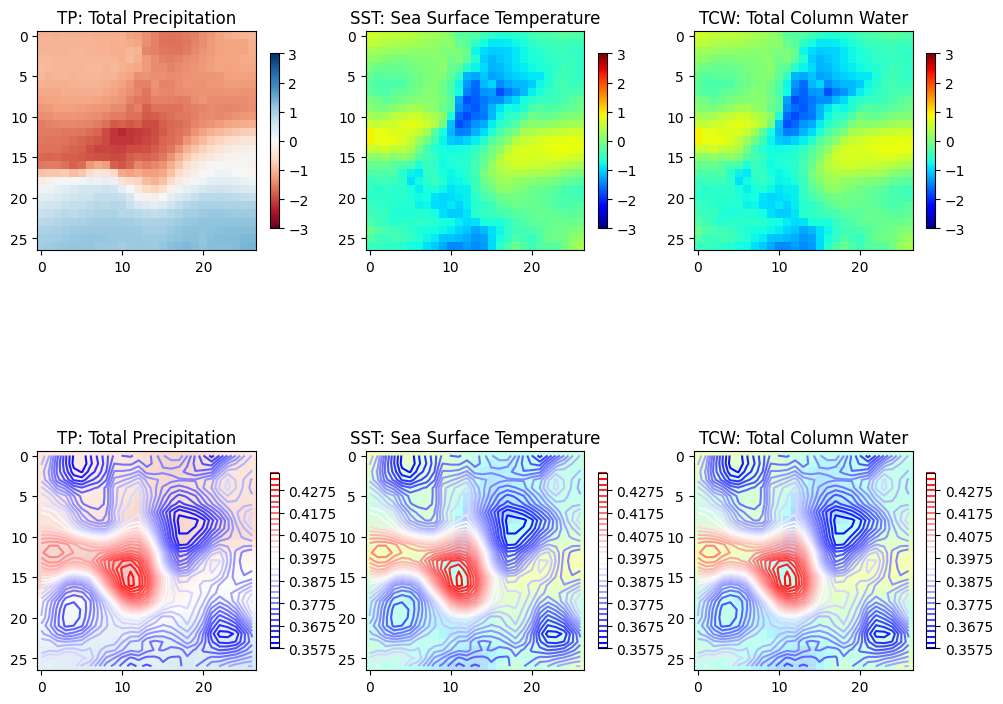

In [98]:
subpl = ['TP: Total Precipitation', 'SST: Sea Surface Temperature', 'TCW: Total Column Water']
cmaps = ['RdBu', 'jet', 'jet']

fig, axs = plt.subplots(2, 3, figsize=(12, 10))

#fig.text(0.5, 0.35, 'Latitude', ha='center')
#fig.text(0.08, 0.5, 'Longitude', va='center', rotation='vertical')

for col in range(3):
    for row in range(2):
        ax = axs[row][col]
        ax.title.set_text(subpl[col])
        if row == 0:
            img = ax.imshow(data_input[:,:,col], cmap=cmaps[col], vmin = -3, vmax = 3)
            cbar = fig.colorbar(img, ax = ax, shrink = 0.5)
        else:
            ax.imshow(data_input[:,:,col], cmap=cmaps[col], vmin = -3, vmax = 3, alpha=0.3)
            img_map = ax.contour(relevances[class_idx][::-1], 30, cmap = 'bwr')
            cbar = fig.colorbar(img_map, ax = ax, shrink = 0.5)